In [1]:
from collections import defaultdict

import numpy as np
import scipy as sp
import pandas as pd
from ipypb import track

from polara.evaluation import evaluation_engine as ee
from polara.evaluation.pipelines import random_grid, find_optimal_config
from polara.recommender.external.turi.turiwrapper import TuriFactorizationRecommender

from data_preprocessing import (get_yahoo_music_data,
                                get_similarity_data,
                                prepare_data_model)
from utils import (report_results, save_results,
                   apply_config, print_data_stats,
                   save_training_time, save_cv_training_time)

%matplotlib inline

In [2]:
from polara.recommender import defaults
defaults.memory_hard_limit = 15 # allowed memory usage during recommendations generation

In [3]:
seed = 42

In [4]:
experiment_name = 'sgd'

# Experiment setup

In [5]:
data_labels = ['YaMus']

In [6]:
# according to https://apple.github.io/turicreate/docs/api/generated/turicreate.recommender.ranking_factorization_recommender.RankingFactorizationRecommender.html
init_config = dict(with_data_feedback = False, # implicit case
                   ranking_optimization = True,
                   solver = 'adagrad',
                   sgd_step_size = 0, # let Turi autotune it
                   seed = seed,
                   max_iterations = 25,
                   other_tc_params = {}
                   )
mf_init_config = dict.fromkeys(data_labels, {'SGD': init_config}) # standard scenario

In [7]:
params = {
          'regularization': [1e-10, 3e-10, 1e-9, 3e-9, 1e-8, 3e-8, 1e-7, 3e-7, 1e-6, 3e-6],
          'linear_regularization': [1e-10, 3e-10, 1e-9, 3e-9, 1e-8, 3e-8, 1e-7, 3e-7, 1e-6, 3e-6],
          'rank': [100] # for initial tuning (exploration)
         }

if init_config['solver'] == 'adagrad':
    params.update({
                   'adagrad_momentum_weighting': [0.9, 0.95, 0.99]
                  })      

In [8]:
ranks_grid = [1, 10, 100, 500, 1000, 2000, 3000]

In [9]:
mf_ranks = {'YaMus': ranks_grid}

In [10]:
topk_values = [1, 3, 10, 20, 30]

In [11]:
target_metric = 'mrr'

In [12]:
data_dict = dict.fromkeys(data_labels)
meta_dict = dict.fromkeys(data_labels)
similarities = dict.fromkeys(data_labels)
sim_indices = dict.fromkeys(data_labels)
feature_idx = dict.fromkeys(data_labels)

In [13]:
all_data = [data_dict, similarities, sim_indices, meta_dict]

## Yahoo Music

In [ ]:
lbl = 'YaMus'

In [ ]:
data_dict[lbl], meta_dict[lbl] = get_yahoo_music_data('/gpfs/gpfs0/e.frolov/recsys/yahoo_music/yamus_train0_rating5.gz',
                                                      meta_path='/gpfs/gpfs0/e.frolov/recsys/yahoo_music/yamus_attrs.gz',
                                                      implicit=True,
                                                      pcore=5,
                                                      filter_data={'genreid': [0]}, # filter unknown genre
                                                      filter_no_meta=True)

In [ ]:
similarities[lbl], sim_indices[lbl], feature_idx[lbl] = get_similarity_data(meta_dict[lbl])

In [ ]:
(meta_dict[lbl].applymap(len).sum(axis=1)==0).mean()

0.0

## Data stats

In [ ]:
print_data_stats(data_labels, all_data)

YaMus
{'userid': 183003, 'songid': 134059}
density 0.09740952587383789
similarity matrix density 0.4576464914574314


# Standard experiment

In [ ]:
def prepare_recommender_models(data_label, data_models, config):
    data_model = data_models[data_label]
    mf = TuriFactorizationRecommender(data_model, item_side_info=None)
    mf.method = 'SGD'
    models = [mf]
    apply_config(models, config, data_label)
    return models

def fine_tune_mf(model, params, label, ntrials=60, record_time_as=None):
    param_grid, param_names = random_grid(params, n=ntrials)
    best_mf_config, mf_scores = find_optimal_config(model, param_grid, param_names,
                                                    target_metric,
                                                    return_scores=True,
                                                    force_build=True,
                                                    iterator=lambda x: track(x, label=label))
    model_config = {model.method: dict(zip(param_names, best_mf_config))}
    model_scores = {model.method: mf_scores}
    try:
        if record_time_as:
            save_training_time(f'{experiment_name}_{record_time_as}', model, mf_scores.index, label)
    finally:
        return model_config, model_scores

## tuning

In [ ]:
config = {}
scores = {}
times = {}
data_models = {}

In [ ]:
mf_init_config['YaMus']['SGD']

{'with_data_feedback': False,
 'ranking_optimization': True,
 'solver': 'adagrad',
 'sgd_step_size': 0,
 'seed': 42,
 'max_iterations': 25,
 'other_tc_params': {}}

In [ ]:
for label in track(data_labels):
    data_models[label] = prepare_data_model(label, *all_data, seed)
    model, = prepare_recommender_models(label, data_models, mf_init_config)
    config[label], scores[label] = fine_tune_mf(model, params, label, ntrials=30, record_time_as='param')
del model

 [████████████████████████████████████████████████████████████] 1/1 [09:07:03<09:07:03, 32823.02s/it]

          YaMus [█████████████████████████████████████████████] 30/30 [09:06:47<19:26, 1093.56s/it]

/trinity/home/e.frolov/.conda/envs/lab/lib/python3.6/site-packages/pandas/plotting/_core.py:1001: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(left, right)


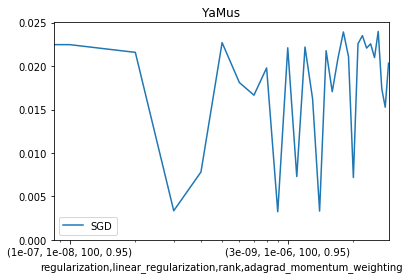

In [ ]:
# no meta
report_results('tuning', scores);

In [ ]:
config

{'YaMus': {'SGD': {'regularization': 3e-08,
   'linear_regularization': 3e-07,
   'rank': 100,
   'adagrad_momentum_weighting': 0.95}}}

### saving data

In [ ]:
save_results(f'{experiment_name}_param', config=config, tuning=scores)

## rank estimation

In [ ]:
rank_config = {}
rank_scores = {}

In [ ]:
for label in track(data_labels):
    model, = prepare_recommender_models(label, data_models,
                                        [mf_init_config, config]) # initiate with optimal config
    rank_config[label], rank_scores[label] = fine_tune_mf(model, {'rank': mf_ranks[label]},
                                                          label, ntrials=0, record_time_as='rank')
del model

 [████████████████████████████████████████████████████████████] 1/1 [04:18:45<04:18:45, 15525.26s/it]

          YaMus [█████████████████████████████████████████████] 7/7 [04:18:45<29:23, 2217.89s/it]

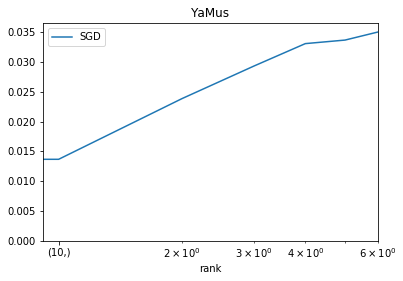

In [ ]:
# no meta
report_results('rank', {lbl: v.sort_index() for lbl, scr in rank_scores.items() for k, v in scr.items()});

In [ ]:
rank_config

{'YaMus': {'SGD': {'rank': 3000}}}

### saving data

In [ ]:
save_results(f'{experiment_name}_rank', config=rank_config, tuning=rank_scores)

## cross-validation

In [ ]:
result = {}
for label in track(data_labels):
    models = prepare_recommender_models(label, data_models, [mf_init_config, config, rank_config])
    result[label] = ee.run_cv_experiment(models,
                                         fold_experiment=ee.topk_test,
                                         topk_list=topk_values,
                                         ignore_feedback=True,
                                         iterator=lambda x: track(x, label=label))
    save_cv_training_time(experiment_name, models, label)

 [############################################################] 0/1 [0<0, 0.00s/it]

          YaMus [██████████████████###########################] 2/5 [02:46:42<01:24:01, 5001.00s/it]

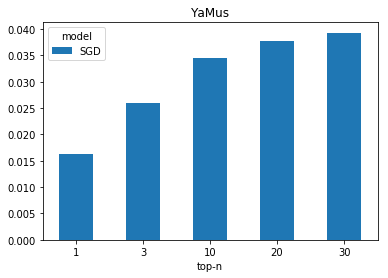

In [36]:
# no meta
report_results('topn', result, target_metric);

In [37]:
pd.concat({lbl: res.mean(level='top-n').loc[10, :'ranking'] for lbl, res in result.items()}, axis=1)

,,YaMus
type,metric,
relevance,hr,0.091452
ranking,mrr,0.034547


### saving data

In [ ]:
save_results(experiment_name, cv=result)